In [1]:
# import mnist

import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:

from mnist import MNIST

In [353]:
def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/1036959/midpoint-of-the-shortest-distance-between-2-rays-in-3d
    '''
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    a, b, c, d = v1, g1, v2, g2
    
    bd = dot(b, d)
    ad = dot(a, d)
    bc = dot(b, c)
    cd = dot(c, d) 
    ab = dot(a, b)
    
    s = (bd*(ad-bc)-ad*cd)/(bd**2.-1.)
    t = (bd*(cd-ad)-bc*ab)/(bd**2.-1.)
    
    return (a+c+b*t[:, None]+d*s[:, None])/2.

def intercept(v1, g1, v2, g2):
    '''
    from: https://math.stackexchange.com/questions/3242011/finding-the-closest-two-points-on-two-lines-in-n-dimensions
    '''
    
    bs = v1.shape[:-1]
    def dot(a, b):
        return (a*b).sum(dim=-1)
    
    g1 = g1/g1.norm(dim=-1, keepdim=True)
    g2 = g2/g2.norm(dim=-1, keepdim=True)
    
    a, b, c, d = v1, g1, v2, g2
    
    # Ax = B
    A = torch.zeros(*bs, 2, 2)
    B = torch.zeros(*bs, 2)
    A[..., 0, 0] = b.norm(dim=-1)**2.
    A[..., 0, 1] = -dot(b, d)
    A[..., 1, 0] = -dot(b, d)
    A[..., 1, 1] = d.norm(dim=-1)**2.
    
    
    B[..., 0] = -dot(a-c, b)
    B[..., 1] = dot(a-c, d)
    
#     print(A)
#     print(torch.matrix_rank(A))
#     print(A.det())
#     print(A.inverse())
    
    st = (A.inverse()@B[..., None])[..., 0]
    s, t = st[..., 0], st[..., 1]
    
    # TODO clip s, t to 0 as lower limit
    
    if s<0 or t<0:
        print('st ', s,t)
    
    return (a+c+b*s[..., None]+d*t[..., None])/2., s, t

In [4]:
torch.manual_seed(1)
v1 = torch.randn(16, 2)
g1 = torch.randn(16, 2)
v2 = torch.randn(16, 2)
g2 = torch.randn(16, 2)

# v1 = torch.tensor([[0, 0.]])
# g1 = torch.tensor([[1, 0.]])
# v2 = torch.tensor([[0, -2.]])
# g2 = torch.tensor([[1, 2.]])/10.


In [5]:
it = intercept(v1, g1, v2, g2)

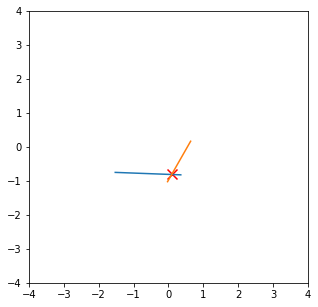

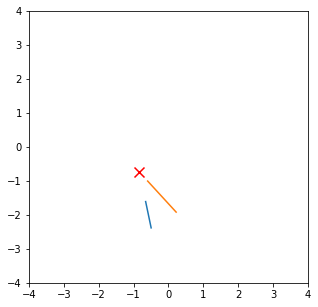

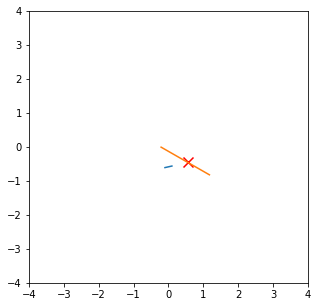

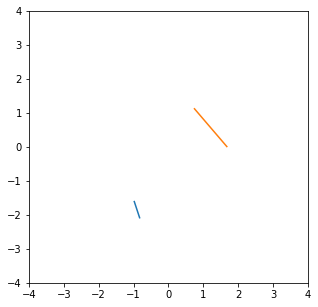

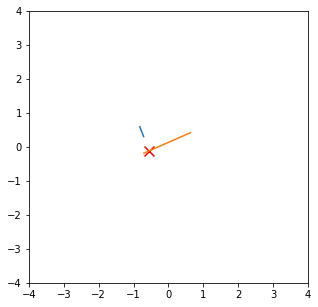

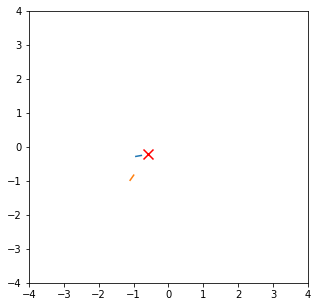

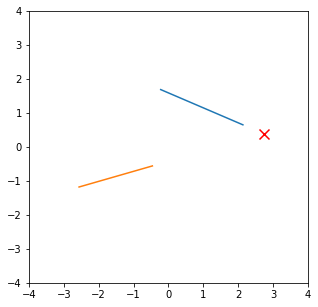

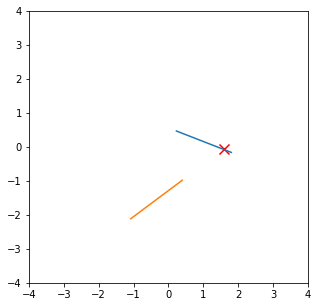

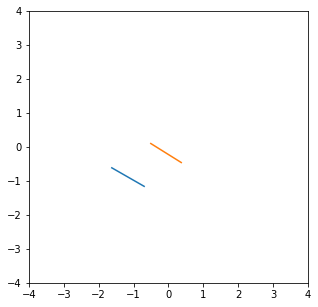

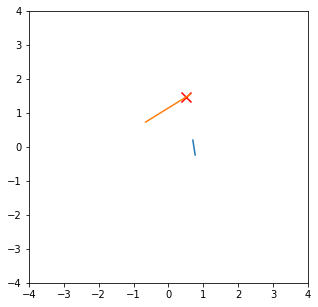

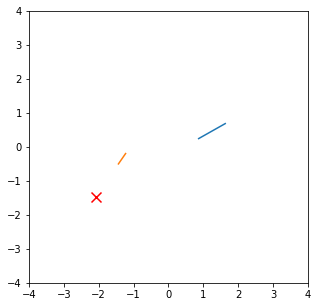

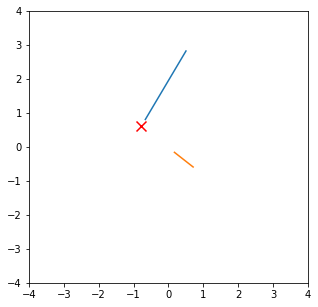

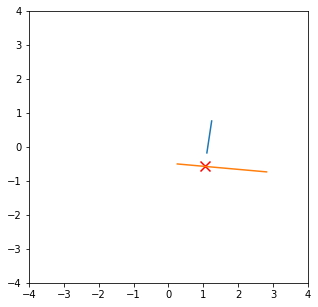

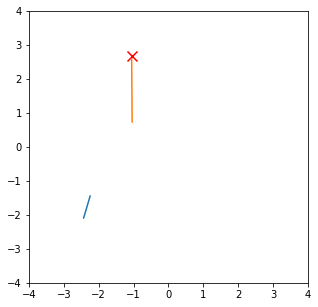

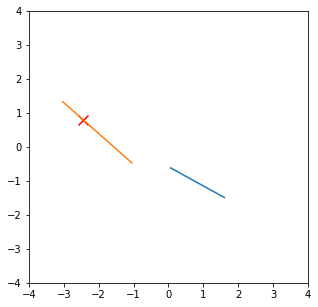

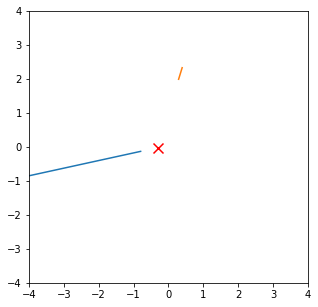

In [7]:

for i in range(len(v1)):
    plt.figure(figsize=(5, 5))
#     plt.quiver(*v1[i], *g1[i], scale=5)
#     plt.quiver(*v2[i], *g2[i], scale=5)
    
    plt.plot(*torch.stack([v1[i], v1[i]+g1[i]]).T)
    plt.plot(*torch.stack([v2[i], v2[i]+g2[i]]).T)
    plt.scatter(*it[i], marker='x', c='r', s=100)
    # plt.scatter(*it1[i], marker='x', c='g', s=100)

    plt.xlim(-4, 4); plt.ylim(-4, 4)
    plt.show()

In [4]:
def fn_quad(x):
    return x.norm(dim=-1)**2

def fg_fn(x, fn):
    x = x.detach().requires_grad_()
    loss = fn(x)
    loss.backward()
    return loss, x.grad

In [5]:
def step_intercept_epsilon(x1, fn, eps=1e-2):
    x2 = x1 + eps*torch.randn_like(x1)
    f1, g1 = fg_fn(x1, fn)
    f2, g2 = fg_fn(x2, fn)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return x3

def step(x):
    fx = func(x)
    gx = grad(x)
    
    t = 1e-5
    while func(x-t*gx)<fx:
        t *= 2
    v1 = x-t/2.*gx
    v2 = x-t*gx
    v2 = v2+torch.randn_like(v2)*.1
    
    g1 = grad(v1)
    g2 = grad(v2)
    
    v3 = intercept(v1, -g1, v2, -g2)
    
    # plt.plot(*torch.stack([v1, (v1-g1/10.)]).T)
    # plt.plot(*torch.stack([v2, (v2-g2/10.)]).T)

    # plt.scatter(*v3, marker='x', c='r', s=100)
        

In [6]:
x1 = (torch.randn(100)*100).requires_grad_()
x2 = (torch.randn(2)*100).requires_grad_()

# f1, g1 = fg_quad(x1)
# f2, g2 = fg_quad(x2)

In [7]:
x1 = (torch.randn(100)).requires_grad_()
x3 = step_intercept_epsilon(x1, fn_quad, eps=1e-2)

In [406]:
# TODO the more parralel the two grad directions, the less you trust my intersection estimate
# use convex combination of (intersection estimate) and (mean of the two base points)

In [280]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.MaxPool2d(3),
        )
        self.classification = nn.Sequential(
            nn.Linear(32, 10),
            nn.LogSoftmax(dim=-1),
        )
    def forward(self, x):
        x = self.seq(x)
        x = x.reshape(len(x), -1)
        x = self.classification(x)
        return x

In [281]:
m = MNIST()

In [326]:
net = Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
print(np.sum([p.numel() for p in net.parameters()]))

net(torch.randn(1,1,28,28))

v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

2162


In [254]:

losses_sgd = []
for x, y in m.loader_train:
    yp = net(x)
    loss = m.loss_func(yp, y)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    print(loss.item())
    losses_sgd.append(loss.item())
    

2.311504602432251
2.3001163005828857
2.2912673950195312
2.2737295627593994
2.243098735809326
2.206475019454956
2.163606643676758
2.085602045059204
1.9814531803131104
1.8512147665023804
1.6852734088897705
1.4972819089889526
1.3906880617141724
1.2315952777862549
1.154175877571106
1.0097368955612183
0.9417338967323303
0.8747764229774475
0.859650731086731
0.7301017642021179
0.7360174059867859
0.661310076713562
0.6275479197502136
0.6483513116836548
0.5209429860115051
0.5630851984024048
0.5971609354019165
0.5640034079551697
0.47822535037994385
0.4354035556316376
0.5039401054382324
0.40314915776252747
0.45070916414260864
0.39802607893943787
0.3957028388977051
0.4146087169647217
0.42348527908325195
0.37420961260795593
0.36233004927635193
0.3966138958930969
0.3418247103691101
0.3672958016395569
0.2545626759529114
0.3028709888458252
0.33829033374786377
0.31423500180244446
0.2791334092617035
0.2114768922328949
0.21880124509334564
0.3136407136917114
0.30597561597824097
0.25133103132247925
0.234376

In [255]:
from tqdm import tqdm

In [256]:
vo = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

In [257]:
fo, g = fg_fn_nn(vo, x, y)
fs = []

for t in tqdm(torch.logspace(-1, -3, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t,f.item()])
fs.append([0, fo.item()])
for t in tqdm(-torch.logspace(-3, -1, 20)):
    f, _ = fg_fn_nn(vo+g*t, x, y)
    fs.append([t, f.item()])
fs = np.array(fs)

100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


(0.1917508840560913, 3.0)

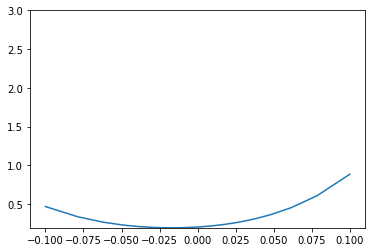

In [258]:
plt.plot(*fs.T)
plt.ylim(fs[:, 1].min(), 3)
# plt.xscale('symlog')

In [356]:
def step_epsilon(x1, x, y, eps=1e-2):
    f1, g1 = fg_fn_nn(x1, x, y)
    
    g1n = g1/g1.norm(dim=-1, keepdim=True)
    x2 = x1 + eps*torch.randn_like(x1)-g1n*eps

    f2, g2 = fg_fn_nn(x2, x, y)
    x3, s, t = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3, s, t

def step_smart(x1, x, y, t=1e-5):
    f1, g1 = fg_fn_nn(x1, x, y)
    
    ft, gt = fg_fn_nn(x1-t*g1, x, y)
    if ft<f1:
        while ft<f1:
            t *= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
    elif ft>f1:
        while ft>f1:
            t /= 2.
            ft, gt = fg_fn_nn(x1-t*g1, x, y)
        t*=2.
        
    x2 = x1-t*g1
    x1 = x1-t/2.*g1
    
    f1, g1 = fg_fn_nn(x1, x, y)
    f2, g2 = fg_fn_nn(x2, x, y)
    x3 = intercept(x1.detach(), -g1.detach(), x2.detach(), -g2.detach())
    return f1, x3

In [357]:
def fg_fn_nn(v, x, y):
    nn.utils.vector_to_parameters(v, net.parameters())
    opt.zero_grad()
    yp = net(x)
    loss = m.loss_func(yp, y)
    loss.backward()
    
    g = torch.cat([p.grad.flatten() for p in net.parameters()])
    return loss, g

In [358]:
net = Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
v = nn.utils.parameters_to_vector(net.parameters()).detach().requires_grad_()

eps = 3e-2
losses = []
for i in range(5):
    for x, y in m.loader_train:
        f1, v2, s, t = step_epsilon(v, x, y, eps)
        if s>0 and t>0:
            v = v2
        # f1, v = step_smart(v, x, y)
        # print('mean abs weight ', x1.abs().mean().item())
        print('loss ', f1.item())
        losses.append(f1.item())
    print('epoch done ', i)

st  tensor(-0.0045) tensor(0.0167)
loss  2.3111190795898438
st  tensor(-0.0663) tensor(-0.0837)
loss  2.3109757900238037
loss  2.3117566108703613
st  tensor(-0.0141) tensor(-0.0131)
loss  2.3069708347320557
loss  2.300931692123413
loss  2.286391019821167
loss  2.2928624153137207
loss  2.2822182178497314
loss  2.276076316833496
loss  2.2716667652130127
loss  2.25223445892334
loss  2.2159833908081055
loss  2.1998634338378906
loss  2.14117169380188
loss  2.1232683658599854
loss  2.0190815925598145
loss  1.9241143465042114
loss  1.9115395545959473
loss  1.8314366340637207
loss  1.8289976119995117
loss  1.7971892356872559
loss  1.7496711015701294
st  tensor(-0.0226) tensor(0.1599)
loss  1.7688918113708496
loss  1.732161045074463
loss  1.7138994932174683
loss  1.6919541358947754
loss  1.6751474142074585
loss  1.6926138401031494
st  tensor(-0.0057) tensor(0.1183)
loss  1.631267786026001
loss  1.6495352983474731
loss  1.603723168373108
loss  1.5671747922897339
loss  1.5798126459121704
loss  1.

In [ ]:
# TODO: sample noise not randomly, but towards negative grad

# TODO: ignore intersection if line s or t values are negative
# (this means go away from the negative grad)

In [304]:
from tqdm import tqdm

In [336]:
losses_sgd = []
   
net = Network()
opt = torch.optim.SGD(net.parameters(), lr=1e-1)
        
for epoch_idx in range(5):
    for x, y in m.loader_train:
        yp = net(x)
        loss = m.loss_func(yp, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses_sgd.append(loss.item())    
    print(loss.item())
        
        

1.7723350524902344
0.45431360602378845
0.3138984739780426
0.20069313049316406
0.20526717603206635


In [338]:
losses_adam = []
   
net = Network()
opt = torch.optim.Adam(net.parameters(), lr=1e-2)
        
for epoch_idx in range(5):
    for x, y in m.loader_train:
        yp = net(x)
        loss = m.loss_func(yp, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses_adam.append(loss.item())    
    print(loss.item())
        
        

0.21000072360038757
0.13306161761283875
0.11994829028844833
0.07587109506130219
0.08116336166858673


(0.0, 2.5)

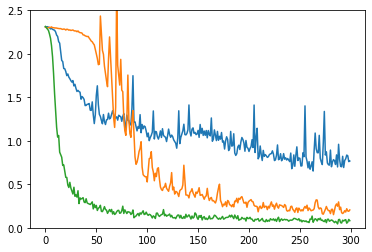

In [359]:
plt.plot(losses)
plt.plot(losses_sgd)
plt.plot(losses_adam)
plt.ylim(0,2.5)